# Two high-level analyses:
- Predict performance (accuracy) using a regression
- Classify users into 'bad' vs 'good'--still need to define this but perhaps the threshold is any user < 70% and any user >= 70%

For github issues and brainstorming features and analyses, use github:
- https://github.com/ProjectSidewalk/sidewalk-quality-analysis/issues

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dateutil import parser as parser
import time
from datetime import datetime, timezone
import csv
from sklearn import svm
import sklearn.feature_selection
from sklearn.feature_selection import SelectFromModel
from sklearn import tree
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold
import requests
import json
import scipy

In [150]:
# users = pd.read_csv('ml-users.csv')
users = pd.read_csv('users_one_mission.csv')
labels = pd.read_csv('ml-label-correctness-one-mission.csv')

In [12]:
# Users w/ accuracies below 65% and are not in neighorhoods without sidewalks
overall_bad_users = ['1353d168-ab49-4474-ae8a-213eb2dafab5', '35872a6c-d171-40d9-8e66-9242b835ea71',
                     '6809bd6e-605f-4861-bc49-32e52c88c675', '939b6faa-0b57-4160-bcc2-d11fd2b69d9f',
                      'f5314ef9-3877-438c-ba65-ee2a2bbbf7f5']

In [13]:
# all the tags belonging to each label type
curb_ramp_tags = ['narrow', 'points into traffic', 'missing friction strip', 'steep', 'not enough landing space']
obstacle_tags = ['fire hydrant', 'pole', 'tree', 'vegetation', 'trash/recycling can', 'parked car', 'parked bike']
missing_curb_ramp_tags = ['alternate route present', 'no alternate route', 'unclear if needed']
surface_problem_tags = ['bumpy', 'uneven', 'cracks', 'grass', 'narrow sidewalk']
no_sidewalk_tags = ['ends abruptly', 'street has a sidewalk', 'street has no sidewalks']
other_tags = ['missing crosswalk', 'no bus stop access']

In [146]:
# parses through each user's csv and figures out how many unique panos and missions seen
user_panos = {}
user_missions = {}
for current_user in users['user_id']:
    df_current = pd.read_csv('{0}.csv'.format(current_user))
    user_panos[current_user] = df_current['gsv_panorama_id'].nunique()
    user_missions[current_user] = df_current['mission_id'].nunique()
df_current = None

In [154]:
temp = pd.read_csv('ml-interactions 2.csv')
temp_grouped = temp.groupby('user_id')
# for current_id, current_group in temp_grouped:
#     user_panos[current_id] = current_group['gsv_panorama_id'].nunique()
#     user_missions[current_id] = current_group['mission_id'].nunique()

In [175]:
# Takes in the row and appends the row into the given file
def file_appender(row, created, user_info):
    if user_info not in created:
        with open('{0}.csv'.format(user_info), 'w', newline = '') as new_user:
            writer = csv.writer(new_user)
            created.append(user_info)
            writer.writerow(header)
    with open('{0}.csv'.format(user_info), 'a', newline = '') as edit_user:
        editor = csv.writer(edit_user)
        editor.writerow(row)
    return created

In [772]:
# Parses through the csv and creates new csv for every user & action
with open('ml-interactions 2.csv', newline = '') as data:
    reader = csv.reader(data)
    header = []
#     users_created = []
    events_created = []
    for row in reader:
        if row[1] == 'user_id':
            header = row
        else:
            user_id = row[1]
            current_event = row[4]
#             users_created = file_appender(row, users_created, user_id)
            events_created = file_appender(row, events_created, current_event)

In [158]:
# Takes all label data from a csv and creates csv of each user's calculated label data
user_labels = {}
labels_grouped = labels.groupby('user_id')
for current_id, current_group in labels_grouped:
    total = len(current_group)
    correct = 0
    false = 0
    accuracy = 0
    label_correctness = current_group['correct'].value_counts()
    if len(label_correctness) > 0:
        correct = label_correctness[0]
        if len(label_correctness) > 1:
            false = label_correctness[1]
    validated = correct + false
    if validated != 0:
        accuracy = float(correct) / float(validated) * 100
    missions_completed = user_missions[current_id]
    user_labels[current_id] = current_id, total, validated, correct, false,  accuracy, missions_completed
header = ['user_id', 'total_labels', 'labels_validated', 'correct_labels', 'false_labels', 'accuracy', 'missions_completed']
with open('users_one_mission.csv', 'w', newline = '') as new_user:
    writer = csv.writer(new_user)
    writer.writerow(header)
for user in user_labels.values():
    with open('users_one_mission.csv', 'a', newline = '') as edit_user:
        editor = csv.writer(edit_user)
        editor.writerow(user)

In [178]:
# Created a csv file of all of the No Sidewalk labels
with open('LabelingCanvas_FinishLabeling.csv', newline = '') as data:
    reader = csv.reader(data)
    for index, row in enumerate(reader):
        if row[1] == 'user_id':
            header = row
        else:
            if index == 0:
                with open('All_Nosidewalk_labels.csv', 'w', newline = '') as new_user:
                        writer = csv.writer(new_user)
                        writer.writerow(header)
            else:
                with open('All_Nosidewalk_labels.csv', 'a', newline = '') as edit_user:
                    editor = csv.writer(edit_user)
                    if 'NoSidewalk' in row[11]:
                        editor.writerow(row)

In [61]:
# Counting the number of tags placed of a certain type
def tag_counter(tag_type_heading, tag_type_kinds, tag_type):
    user_information = {}
    df_information = pd.read_csv('ContextMenu_TagAdded.csv')
    df_grouped = df_information.groupby(['user_id'])
    for current, group in df_grouped:
        users_index = (users['user_id'] == current).idxmax()
        tags_count = 0
        for current_index, current_type in enumerate(group['note']):
            beginning_length = current_type.find('tagName:') + 8 
            ending_length = 13 + len(str(group['audit_task_id'].iloc[current_index]))
            if current_type[beginning_length:-ending_length] in tag_type_kinds:
                tags_count += 1
        current_accuracy = users['accuracy'][users_index]
        if tag_type != None:
            current_accuracy = label_type_accuracy[current, tag_type] * 100
        user_information[current] = tags_count, current_accuracy, users['accuracy'][users_index]
    for index, current_user in enumerate(users['user_id']):
        if current_user not in user_information:
            user_information[current_user] = 0, users['accuracy'][index], users['accuracy'][users_index]
    tag_scatter_plot(tag_type_heading, user_information)

In [135]:
# Used to create a correlation between accuracy and the info type that was given
# It accepts a string for the actions that will be used to record the info type
# graph_type determines how the information is shown and multi_plot determines if it can
# be shows in per panos & per mission.
def counting_graph (info_type, graph_type, multi_plot, action):
    user_information = {}
    df_information = pd.read_csv('{0}.csv'.format(action))
    df_actions_grouped = df_information.groupby(['user_id'])
    for index, current_id in enumerate(df_actions_grouped.groups):
        users_index = (users['user_id'] == current_id).idxmax()
        user_information[current_id] = len(df_actions_grouped.get_group(current_id)), users['accuracy'][users_index]
    for index, current_user in enumerate(users['user_id']):
        if current_user not in user_information:
            user_information[current_user] = 0, users['accuracy'][index]
    if graph_type == 'scatter_plot':
        scatter_plot(info_type, user_information, multi_plot)
    elif graph_type == 'histogram':
        histogram(info_type, user_information)

In [136]:
# Creates a scatter plot of the information given, if multi_plot is true then it is also
# divided by the number of unique panos seens and missions started
def scatter_plot(info_type, user_information, multi_plot):
    if multi_plot:
        user_information_pano = []
        user_information_mission = []
        f, axs = plt.subplots(1,3,figsize=(12,4))
        plt.subplot(133)
        plt.ylabel('User Accuracy')
        plt.xlabel(info_type + ' per Pano')
        for entry in user_information.keys():
            user_info = user_information.get(entry)
            info = float(user_info[0]) / float(user_panos[entry])
            accuracy = user_info[1]
            user_information_pano.append([info,accuracy])
            if entry in overall_bad_users: 
#             if accuracy < 65:
                plt.plot(info, accuracy, '.', color = 'red')
            elif accuracy < 65:
                plt.plot(info, accuracy, '.', color = 'black')
            else:
                plt.plot(info, accuracy, '.', color = 'blue')
        temp = np.array(user_information_pano)
        z = np.polyfit(temp[:,0],temp[:,1],1)
        w = np.poly1d(z)
        pears= scipy.stats.pearsonr(temp[:,1], w(temp[:,0]))
        plt.plot(temp[:,0],w(temp[:,0]))
        plt.legend(['R =' + str(f'{pears[0]:.2f}')])
        plt.subplot(132)
        plt.ylabel('User Accuracy')
        plt.xlabel(info_type + ' per Mission Started')
        for entry in user_information.keys():
            user_info = user_information.get(entry)
            info = float(user_info[0]) / float(user_missions[entry])
            accuracy = user_info[1]
            user_information_mission.append([info,accuracy])
            if entry in overall_bad_users: 
#             if accuracy < 65:
                plt.plot(info, accuracy, '.', color = 'red')
            elif accuracy < 65:
                plt.plot(info, accuracy, '.', color = 'black')
            else:
                plt.plot(info, accuracy, '.', color = 'blue')
        temp = np.array(user_information_mission)
        z = np.polyfit(temp[:,0],temp[:,1],1)
        w = np.poly1d(z)
        pears= scipy.stats.pearsonr(temp[:,1], w(temp[:,0]))
        plt.plot(temp[:,0],w(temp[:,0]))
        plt.legend(['R =' + str(f'{pears[0]:.2f}')])
        plt.subplot(131)
    plt.ylabel('User Accuracy')
    plt.xlabel(info_type)
    for entry in user_information.keys():
        user_info = user_information.get(entry)
        info = user_info[0]
        accuracy = user_info[1]
        if entry in overall_bad_users:
#         if accuracy > 65:
            plt.plot(info, accuracy, '.', color = 'red')
        elif accuracy < 65:
                plt.plot(info, accuracy, '.', color = 'black')
        else:
            plt.plot(info, accuracy, '.', color = 'blue')
    temp = np.array(list(user_information.values()))
    z = np.polyfit(temp[:,0],temp[:,1],1)
    w = np.poly1d(z)
    pears= scipy.stats.pearsonr(temp[:,1], w(temp[:,0]))
    plt.plot(temp[:,0],w(temp[:,0]))
    plt.legend(['R =' + str(f'{pears[0]:.2f}')])

In [137]:
# Creates a scatter plot based off of the accuracy of a specific tag type but colors by
# overall accuracy
def tag_scatter_plot(info_type, user_information):
    plt.ylabel('User Accuracy')
    plt.xlabel(info_type)
    for entry in user_information.keys():
        user_info = user_information.get(entry)
        info = user_info[0]
        accuracy = user_info[1]
        total_accuracy = user_info[2]
        if entry in overall_bad_users:
#         if accuracy > 65:
            plt.plot(info, accuracy, '.', color = 'red')
        elif total_accuracy < 65:
                plt.plot(info, accuracy, '.', color = 'black')
        else:
            plt.plot(info, accuracy, '.', color = 'blue')
    temp = np.array(list(user_information.values()))
    z = np.polyfit(temp[:,0],temp[:,1],1)
    w = np.poly1d(z)
    pears= scipy.stats.pearsonr(temp[:,1], w(temp[:,0]))
    plt.plot(temp[:,0],w(temp[:,0]))
    plt.legend(['R =' + str(f'{pears[0]:.2f}')])

In [138]:
#Creates a histogram counting the occurances of a certain type of information
def histogram(info_type, user_information):
    plt.hist(user_information)
    plt.xlabel(info_type)
    plt.ylabel('Count')

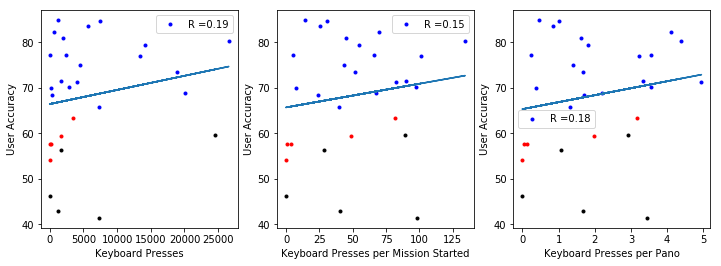

In [68]:
# Counts the number of keyboard presses
counting_graph('Keyboard Presses', 'scatter_plot', True, 'LowLevelEvent_keydown_old')

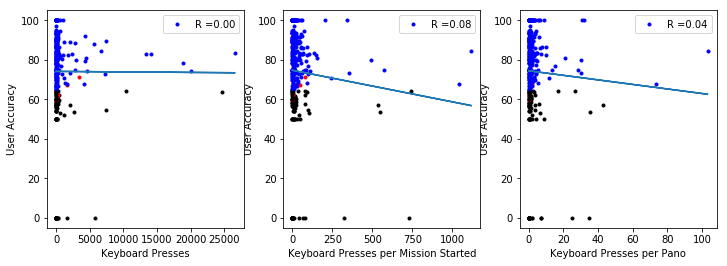

In [151]:
# Counts the number of keyboard presses
counting_graph('Keyboard Presses', 'scatter_plot', True, 'LowLevelEvent_keydown')

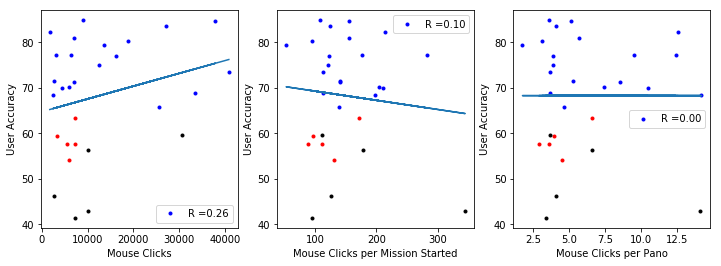

In [70]:
# Counts the number of mouse clicks
counting_graph('Mouse Clicks', 'scatter_plot', True, 'LowLevelEvent_mousedown_old')

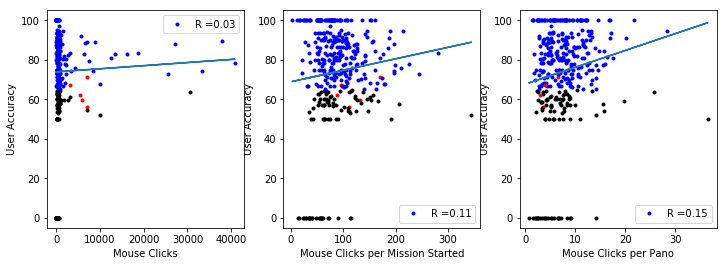

In [152]:
# Counts the number of mouse clicks
counting_graph('Mouse Clicks', 'scatter_plot', True, 'LowLevelEvent_mousedown')

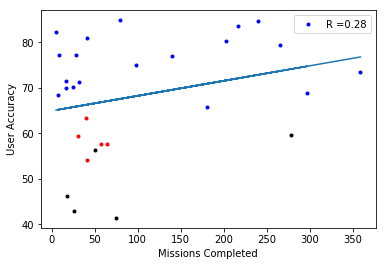

In [71]:
# Counts the number of missions completed
counting_graph('Missions Completed', 'scatter_plot', False, 'MissionComplete_old')

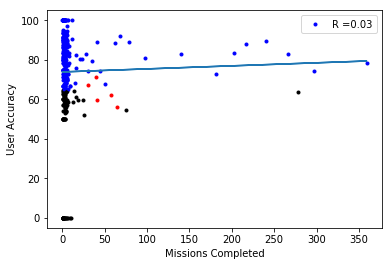

In [153]:
# Counts the number of missions completed
counting_graph('Missions Completed', 'scatter_plot', False, 'MissionComplete')

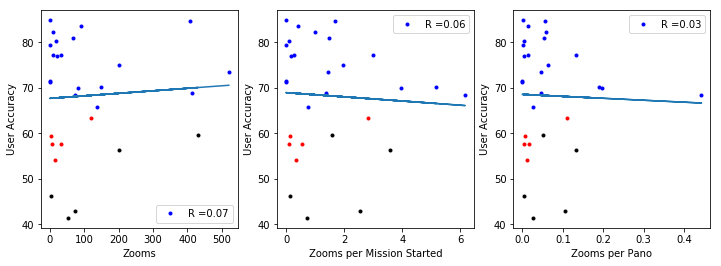

In [72]:
# Counts the number of zooms
counting_graph('Zooms', 'scatter_plot', True, 'Click_ZoomIn')

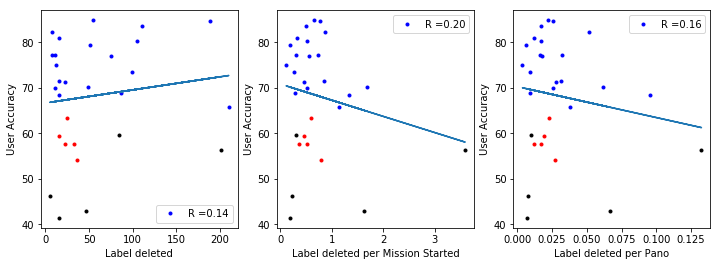

In [73]:
# Counts the number of Labels Deleted
counting_graph('Label deleted', 'scatter_plot', True, 'RemoveLabel')

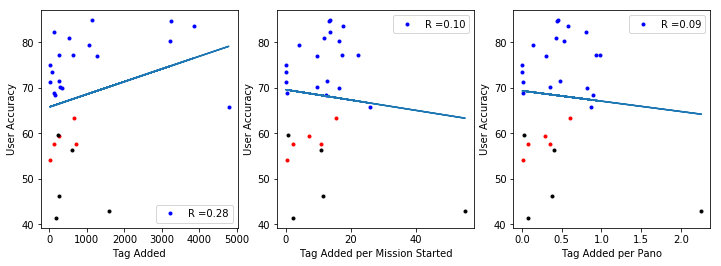

In [74]:
# Counts the total number of Tags Placed
counting_graph('Tag Added', 'scatter_plot', True, 'ContextMenu_TagAdded')

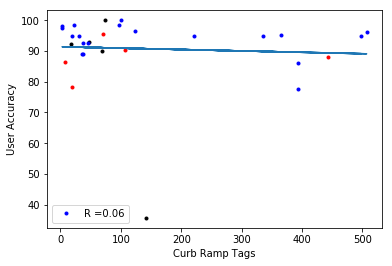

In [56]:
# number of curb ramp label tags compared to curb ramp accuracy
tag_counter('Curb Ramp Tags', curb_ramp_tags, 'CurbRamp')

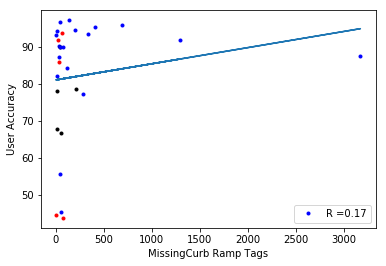

In [57]:
# Number of missing curb ramp label tags compared to missing curb ramp accuracy
tag_counter('MissingCurb Ramp Tags', missing_curb_ramp_tags, 'NoCurbRamp')

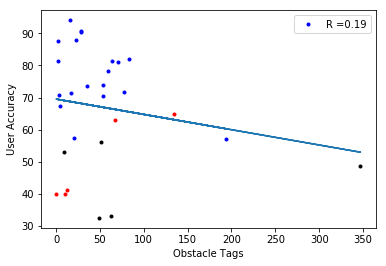

In [58]:
# number of obstacle label tags compared to obstacle accuracy
tag_counter('Obstacle Tags', obstacle_tags, 'Obstacle')

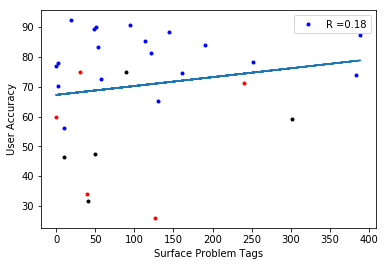

In [59]:
# number of surface problem label tags compared to surface problem accuracy
tag_counter('Surface Problem Tags', surface_problem_tags, 'SurfaceProblem')

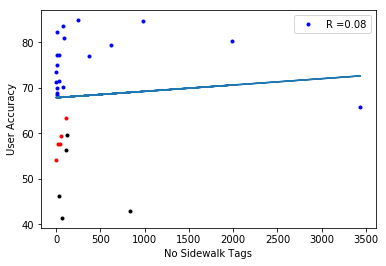

In [47]:
# Number of no sidewalk label tags compared to user accuracy
tag_counter('No Sidewalk Tags', no_sidewalk_tags, None)

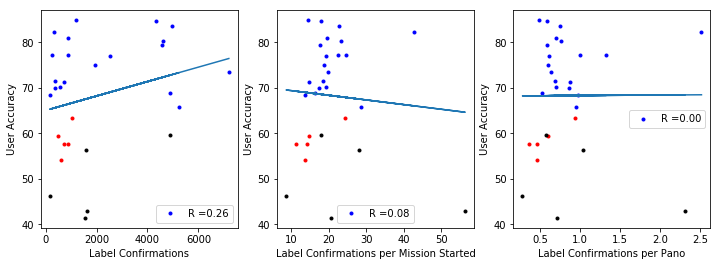

In [213]:
# Counts the number of Label Confirmation based off of closing the context window
counting_graph('Label Confirmations', 'scatter_plot', True, 'LabelingCanvas_FinishLabeling')

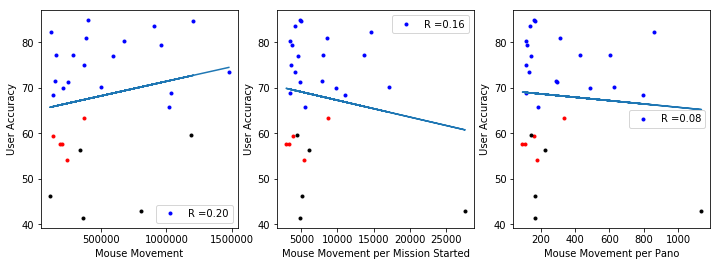

In [75]:
counting_graph('Mouse Movement', 'scatter_plot', True, 'LowLevelEvent_mousemove')

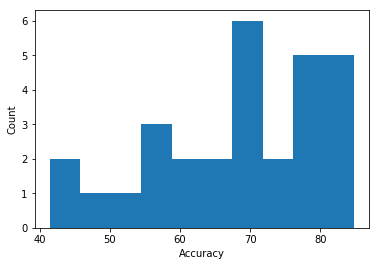

In [885]:
# Counts the number of users with different accuracies
histogram('Accuracy', users['accuracy'])

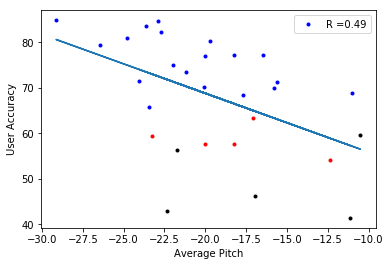

In [77]:
# Finds the average pitch, how far up or down the users is usally looking
user_information = {}
for index, current_id in enumerate(users['user_id']):
    df_current_user = pd.read_csv('{0}.csv'.format(current_id))
    user_information[current_id] = df_current_user['pitch'].mean(), users['accuracy'][index]
scatter_plot('Average Pitch', user_information, False)

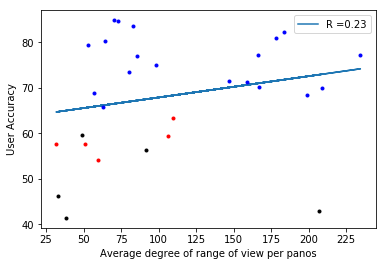

In [152]:
# Calculates the average range of how much a person looks looks side to side
user_information = {}
for index, current_id in enumerate(users['user_id']):
    df_current_user = pd.read_csv('{0}.csv'.format(current_id))
    df_grouped = df_current_user.groupby(['gsv_panorama_id'])
    current_heading = []
    for current, group in df_grouped:
        range = group['heading'].max() - group['heading'].min()
        current_heading.append(range)
        user_information[current_id] = (sum(current_heading) / float(len(current_heading))),users['accuracy'][index]
scatter_plot('Average degree of range of view per panos', user_information, False, False, None)

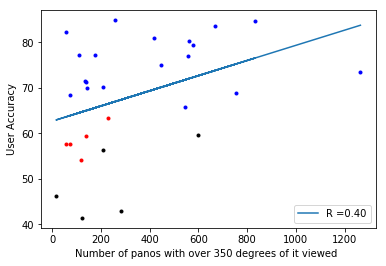

In [150]:
# Counts the number of times a user looks atleast 350 degrees of a pano
user_information = {}
for index, current_id in enumerate(users['user_id']):
    df_current_user = pd.read_csv('{0}.csv'.format(current_id))
    df_grouped = df_current_user.groupby(['gsv_panorama_id'])
    full_heading_count = 0
    for current, group in df_grouped:
        range = group['heading'].max() - group['heading'].min()
        if range >= 350:
            full_heading_count += 1
    user_information[current_id] = full_heading_count, users['accuracy'][index]
scatter_plot('Number of panos with over 350 degrees of it viewed ', user_information, False, False, None)

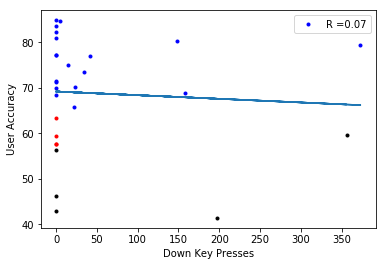

In [79]:
# Number of times the down key is pressed
user_information = {}
df_information = pd.read_csv('LowLevelEvent_keydown.csv')
df_grouped = df_information.groupby(['user_id'])
for current, group in df_grouped:
    users_index = (users['user_id'] == current).idxmax()
    count = sum(group['note'].str.count('keyCode:40'))
    user_information[current] = count , users['accuracy'][users_index]
scatter_plot('Down Key Presses', user_information, False)

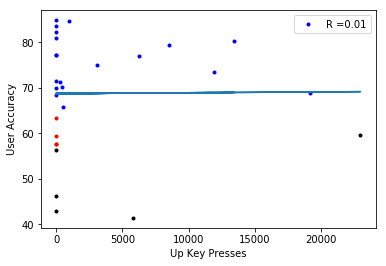

In [81]:
# Number of times the up key is pressed
user_information = {}
df_information = pd.read_csv('LowLevelEvent_keydown.csv')
df_grouped = df_information.groupby(['user_id'])
for current, group in df_grouped:
    users_index = (users['user_id'] == current).idxmax()
    count = sum(group['note'].str.count('keyCode:38'))
    user_information[current] = count , users['accuracy'][users_index]
scatter_plot('Up Key Presses', user_information, False)

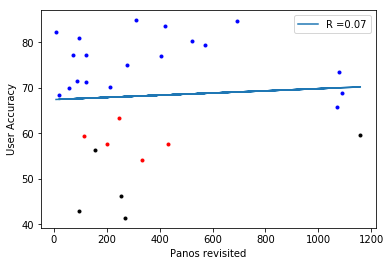

In [148]:
# Counts the number of times a user goes back to a pano they've already been in during the
# same mission
user_information = {}
df_information = pd.read_csv('PanoId_Changed.csv')
df_grouped = df_information.groupby(['user_id'])
for current, group in df_grouped:
    users_index = (users['user_id'] == current).idxmax()
    mission_id = 0
    current_user_duplicates = 0
    total_user_duplicates = 0
    current_panos_seen = []
    for index, current_pano in enumerate(group['gsv_panorama_id']):
        current_mission = group['mission_id'].iloc[index]
        if current_mission != mission_id:
            total_user_duplicates += current_user_duplicates
            current_user_duplicates = 0
            current_panos_seen = [current_pano]
            mission_id = current_mission
        else:
            if current_pano in current_panos_seen:
                current_user_duplicates += 1
            else:
                current_panos_seen.append(current_pano)
    user_information[current] = total_user_duplicates, users['accuracy'][users_index]
scatter_plot('Panos revisited', user_information, False)

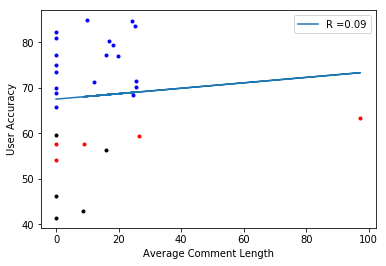

In [183]:
#  Calculates the average length of comments
user_information = {}
df_information = pd.read_csv('ContextMenu_TextBoxChange.csv')
df_grouped = df_information.groupby(['user_id'])
for current, group in df_grouped:
    users_index = (users['user_id'] == current).idxmax()
    comment_length_total = 0
    comment_count = 0
    for index, current_comment in enumerate(group['note']):
        audit_task_id = group['audit_task_id'].iloc[index]
        end_length = len(str(audit_task_id)) + 13
        current_comment = current_comment[11:-end_length]
        comment_count += 1
        comment_length_total += len(current_comment)
    user_information[current] = float(comment_length_total) / comment_count, users['accuracy'][users_index]
for index, current_user in enumerate(users['user_id']):
    if current_user not in user_information:
        user_information[current_user] = 0, users['accuracy'][index]
scatter_plot('Average Comment Length', user_information, False)

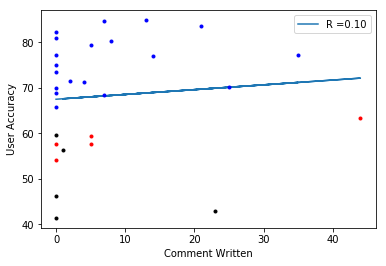

In [174]:
# Counts the number of Comments Written
user_information = {}
df_information = pd.read_csv('ContextMenu_TextBoxChange.csv')
df_grouped = df_information.groupby(['user_id'])
for index, current_id in enumerate(df_grouped.groups):
    users_index = (users['user_id'] == current_id).idxmax()
    user_information[current_id] = len(df_grouped.get_group(current_id)), users['accuracy'][users_index]
for index, current_user in enumerate(users['user_id']):
    if current_user not in user_information:
        user_information[current_user] = 0, users['accuracy'][index]
temp = np.array(list(user_information.values()))
z = np.polyfit(temp[:,0],temp[:,1],1)
w = np.poly1d(z)
pears= scipy.stats.pearsonr(temp[:,1], w(temp[:,0]))
plt.plot(temp[:,0],w(temp[:,0]))
plt.legend(['R =' + str(f'{pears[0]:.2f}')])
scatter_plot('Comment Written', user_information, False)

In [217]:
# Creates a lists of each user's outputs (Quality 0 = Bad, 1 = Good, and accuracy)
# Also creates an list for features
def create_groups():
    for index, entry in enumerate(users['user_id']):
        current_accuracy = users['accuracy'][index]
        if current_accuracy <= 65:
            quality = '0'
        else:
            quality = '1'
        all_output.append([quality, current_accuracy, entry in overall_bad_users])
        all_data.append([0])
        all_id.append(entry)

In [220]:
# Adds a feature into the features list of both the training and testing model
# Feature is the name of the user action that is recorded
def add_feature(feature, info_type, feature_title, multi):
    if feature_title not in all_feature_header:
        for index, entry in enumerate(users['user_id']):
            df_user = pd.read_csv('{0}.csv'.format(entry))
            action_count = df_user['action'].value_counts()
            if feature in action_count:
                #if info_type == 'count':
                missions = action_count[feature] / float(user_missions[entry])
                if info_type == 'time':
                    missions = missions / user_times[entry]
            elif info_type == 'pitch':
                info = df_user['pitch'].mean()     
            elif info_type == 'heading':
                df_grouped = df_user.groupby(['gsv_panorama_id'])
                current_heading = []
                for current, group in df_grouped:
                    current_heading.append(group['heading'].max() - group['heading'].min())
                info = (sum(current_heading) / float(len(current_heading))) 
            elif info_type == 'heading 350':
                df_grouped = df_user.groupby(['gsv_panorama_id'])
                full_heading_count = 0
                for current, group in df_grouped:
                    range = group['heading'].max() - group['heading'].min()
                    if range >= 350:
                        full_heading_count += 1
                info = full_heading_count
            else:
                missions = 0
            if multi:
                current_index = all_id.index(entry)
                all_data[current_index].append(missions)
            else:
                current_index = all_id.index(entry)
                all_data[current_index].append(info)
        if multi:
            all_feature_header.append(feature_title + ' per Mission')
        else:
            all_feature_header.append(feature_title)

In [219]:
# Creates empty lists to hold all of the user data
all_data = []
all_id = []
all_output = []
all_feature_header = ['test']
output_header = ['Quality', 'Accuracy', 'No Sidewalk Neighborhoods']
create_groups()

In [222]:
display(all_data)
display(all_id)
display(all_output)
display(all_feature_header)

[[0,
  80.60252065420194,
  1265,
  -21.15926586977427,
  0.17857142857142858,
  19.76098901098901,
  0.27197802197802196,
  51.752747252747255],
 [0,
  51.05359773510416,
  72,
  -20.037270042145735,
  10.9375,
  11.140625,
  0.515625,
  0.96875],
 [0,
  72.75005308041966,
  833,
  -22.913363875577915,
  13.333333333333334,
  17.847736625514404,
  0.7777777777777778,
  30.45679012345679],
 [0,
  109.9231549271215,
  230,
  -17.094591308250653,
  15.547619047619047,
  24.30952380952381,
  0.5952380952380952,
  81.80952380952381],
 [0,
  82.70934695565448,
  667,
  -23.614854446813293,
  17.689497716894977,
  22.602739726027398,
  0.5068493150684932,
  25.625570776255707],
 [0,
  207.11626459699508,
  280,
  -22.372120062392113,
  55.10344827586207,
  56.310344827586206,
  1.6206896551724137,
  40.58620689655172],
 [0,
  59.58281299544307,
  118,
  -12.331478498128579,
  0.3111111111111111,
  13.666666666666666,
  0.8,
  0],
 [0,
  64.25151152641911,
  563,
  -19.731631314501747,
  16.2

['0e1ae564-6d72-4670-98e4-71369cc5ab26',
 '1353d168-ab49-4474-ae8a-213eb2dafab5',
 '2d9009b3-55d5-4aa8-a17a-a7c80afc4d51',
 '35872a6c-d171-40d9-8e66-9242b835ea71',
 '49723673-044d-4b47-855b-3bdebfe37073',
 '54c77d0f-fc8f-4497-84d3-5e336047b17e',
 '6809bd6e-605f-4861-bc49-32e52c88c675',
 '715af4d8-0f17-47c4-99c6-7ef92d94803a',
 '7b1596af-14d4-4f2b-9e4e-71b1884db836',
 '86d26e9d-010f-4802-88ba-680ae0a8e20d',
 '87833d72-b357-4e2c-81cd-23f58ff04c59',
 '8a471c0f-fa81-4c57-9b65-bd04a92c6a5e',
 '9005a64a-fa73-4c84-b08b-b61eece1b9b7',
 '939b6faa-0b57-4160-bcc2-d11fd2b69d9f',
 '9b595ba6-529b-4d37-93d7-dd189184e15a',
 'ac272eb8-3bb3-4260-9960-8e6c463f3867',
 'af812204-1521-4c42-bf88-4baaaffe3f06',
 'bb64c416-b0bb-4a5b-b369-00f2a56fea3a',
 'bca24c1a-a6b1-4625-ab8e-9ff8693022d7',
 'bf16418a-4c99-4fd6-99c6-7e8b40fbe17b',
 'c7190807-b56e-40c5-b96e-49dc8368328c',
 'd3636d4c-2d16-410c-bf44-c066ecaf1c31',
 'dada416e-535f-4bb3-a213-172a8a94b581',
 'dce5984b-25d9-48f9-b8b7-640202b3be3c',
 'e4ff325c-309b-

[['1', 73.42657342657343, False],
 ['0', 57.608695652173914, True],
 ['1', 84.68085106382978, False],
 ['0', 63.34164588528678, True],
 ['1', 83.49917081260365, False],
 ['0', 42.857142857142854, False],
 ['0', 54.11764705882353, True],
 ['1', 80.2734375, False],
 ['1', 74.93975903614458, False],
 ['0', 41.43302180685358, False],
 ['1', 77.26980038634899, False],
 ['0', 46.15384615384615, False],
 ['1', 70.1923076923077, False],
 ['0', 59.32203389830509, True],
 ['1', 77.19780219780219, False],
 ['1', 80.9322033898305, False],
 ['1', 79.46257197696737, False],
 ['1', 84.82758620689654, False],
 ['1', 65.80027359781121, False],
 ['1', 76.90476190476191, False],
 ['1', 69.91150442477877, False],
 ['0', 56.41025641025641, False],
 ['1', 68.4931506849315, False],
 ['1', 71.42857142857143, False],
 ['1', 71.3015873015873, False],
 ['0', 59.68882602545968, False],
 ['1', 68.8, False],
 ['0', 57.692307692307686, True],
 ['1', 82.17573221757323, False]]

['test',
 'Average Heading Range',
 'Panos w/ over 350 Degrees seen',
 'Average Pitch',
 'Tags Added per Mission',
 'Labels Confirmed per Mission',
 'Labels Removed per Mission',
 'Key Presses per Mission']

In [221]:
# adds these features into the lists
add_feature( None, 'heading', 'Average Heading Range', False)
add_feature( None, 'heading 350', 'Panos w/ over 350 Degrees seen', False)
add_feature( None, 'pitch', 'Average Pitch', False)
add_feature( 'ContextMenu_TagAdded', 'count', 'Tags Added', True)
add_feature( 'LabelingCanvas_FinishLabeling', 'count', 'Labels Confirmed', True)
add_feature( 'RemoveLabel', 'count', 'Labels Removed', True)
add_feature( 'LowLevelEvent_keydown', 'count', 'Key Presses', True)

In [1557]:
# Adds the quality of each user as a feature if needed
for index, entry in enumerate(users['user_id']):
    current_accuracy = users['accuracy'][index]
    if entry in overall_bad_users:
        info = 'Overall Bad User'
    elif current_accuracy <= 65:
        info = 'Bad User in Neighborhoods Without Sidewalks'
    else:
        info = 'Good User'
    current_index = all_id.index(entry)
    all_data[current_index][7] = info

In [88]:
# Creates dataframes of the users features, and their outputs
df_all = pd.DataFrame(all_data, columns = all_feature_header, index = all_id)
df_all_output = pd.DataFrame(all_output, columns = output_header, index = all_id)

NameError: name 'all_data' is not defined

In [227]:
# Creates csv's out of the dataframes
df_all.to_csv('all_users.csv', encoding='utf-8', index=False)
df_all_output.to_csv('all_users_outputs.csv', encoding='utf-8', index=False)

In [118]:
# Drops the testing column
df_all = df_all.drop(columns=['test'])
df_all_features = df_all.iloc[:, :6]
df_all_features_output = df_all_output.iloc[:, :6]

In [120]:
# Creates dataframes for training and test
number_of_training = 22
df_training = df_all.iloc[:number_of_training, :6]
df_test = df_all.iloc[number_of_training:, :6]
df_test_output = df_all_output.iloc[number_of_training:, :]
df_training_output = df_all_output.iloc[:number_of_training, :]

In [121]:
print('all')
display(df_all)
print('all outputs')
display(df_all_output)

all


,test,Average Heading Range,Average Pitch,Mouse Clicks per Mission,Labels Confirmed per Mission,Labels Removed per Mission,Key Presses per Mission
0e1ae564-6d72-4670-98e4-71369cc5ab26,0,80.602521,-21.159266,112.269231,19.760989,0.271978,51.752747
1353d168-ab49-4474-ae8a-213eb2dafab5,0,51.053598,-20.037270,111.359375,11.140625,0.515625,0.968750
2d9009b3-55d5-4aa8-a17a-a7c80afc4d51,0,72.750053,-22.913364,156.037037,17.847737,0.777778,30.456790
35872a6c-d171-40d9-8e66-9242b835ea71,0,109.923155,-17.094591,171.047619,24.309524,0.595238,81.809524
49723673-044d-4b47-855b-3bdebfe37073,0,82.709347,-23.614854,124.205479,22.602740,0.506849,25.625571
54c77d0f-fc8f-4497-84d3-5e336047b17e,0,207.116265,-22.372120,344.379310,56.310345,1.620690,40.586207
6809bd6e-605f-4861-bc49-32e52c88c675,0,59.582813,-12.331478,131.577778,13.666667,0.800000,0.000000
715af4d8-0f17-47c4-99c6-7ef92d94803a,0,64.251512,-19.731631,94.752525,23.348485,0.530303,134.242424
7b1596af-14d4-4f2b-9e4e-71b1884db836,0,98.297571,-22.002347,121.194175,18.776699,0.116505,43.592233
86d26e9d-010f-4802-88ba-680ae0a8e20d,0,38.040449,-11.129766,95.413333,20.466667,0.200000,98.373333


all outputs


,Quality,Accuracy,Overall Bad User
0e1ae564-6d72-4670-98e4-71369cc5ab26,1,73.426573,False
1353d168-ab49-4474-ae8a-213eb2dafab5,0,57.608696,True
2d9009b3-55d5-4aa8-a17a-a7c80afc4d51,1,84.680851,False
35872a6c-d171-40d9-8e66-9242b835ea71,0,63.341646,True
49723673-044d-4b47-855b-3bdebfe37073,1,83.499171,False
54c77d0f-fc8f-4497-84d3-5e336047b17e,0,42.857143,False
6809bd6e-605f-4861-bc49-32e52c88c675,0,54.117647,True
715af4d8-0f17-47c4-99c6-7ef92d94803a,1,80.273438,False
7b1596af-14d4-4f2b-9e4e-71b1884db836,1,74.939759,False
86d26e9d-010f-4802-88ba-680ae0a8e20d,0,41.433022,False


In [9]:
print('test')
display(df_test)
print('training')
display(df_training)
print('test outputs')
display(df_test_output)
print('training outputs')
display(df_training_output)

In [1848]:
print('test')
display(df_test_new)
print('training')
display(df_training_new)

test


array([[199.11119076, -17.666649  ,  23.58333333, 197.91666667,
         13.58333333,   1.33333333],
       [151.63527289, -24.07594897,  85.25      , 137.9375    ,
         17.625     ,   0.875     ],
       [161.54052   , -15.61233502,  83.20833333, 145.16666667,
         14.4375    ,   0.47916667],
       [ 48.85967159, -10.49890763,  89.37090909, 111.45818182,
         17.82181818,   0.30545455],
       [ 56.77880249, -11.03382562,  67.59259259, 112.44781145,
         16.42424242,   0.29292929],
       [ 31.66814815, -18.2397561 ,   3.96721311,  88.24590164,
         14.13114754,   0.36065574],
       [183.74719388, -22.70514452,  69.625     , 213.375     ,
         42.75      ,   0.875     ]])

training


array([[ 8.06025207e+01, -2.11592659e+01,  5.17527473e+01,
         1.12269231e+02,  1.97609890e+01,  2.71978022e-01],
       [ 5.10535977e+01, -2.00372700e+01,  9.68750000e-01,
         1.11359375e+02,  1.11406250e+01,  5.15625000e-01],
       [ 7.27500531e+01, -2.29133639e+01,  3.04567901e+01,
         1.56037037e+02,  1.78477366e+01,  7.77777778e-01],
       [ 1.09923155e+02, -1.70945913e+01,  8.18095238e+01,
         1.71047619e+02,  2.43095238e+01,  5.95238095e-01],
       [ 8.27093470e+01, -2.36148544e+01,  2.56255708e+01,
         1.24205479e+02,  2.26027397e+01,  5.06849315e-01],
       [ 2.07116265e+02, -2.23721201e+01,  4.05862069e+01,
         3.44379310e+02,  5.63103448e+01,  1.62068966e+00],
       [ 5.95828130e+01, -1.23314785e+01,  0.00000000e+00,
         1.31577778e+02,  1.36666667e+01,  8.00000000e-01],
       [ 6.42515115e+01, -1.97316313e+01,  1.34242424e+02,
         9.47525253e+01,  2.33484848e+01,  5.30303030e-01],
       [ 9.82975714e+01, -2.20023468e+01,  4.359

In [127]:
# SVM Classifier model
clf = svm.SVC(C = 100, gamma = 'auto', kernel = 'linear')
clf.fit(df_training_new, df_training_output['Quality'])

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [1974]:
# SVM Regression Model
clf = svm.SVR(C = 100, gamma = 'auto', kernel = 'linear')
clf.fit(df_training_new, df_training_output['Accuracy'])

SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [2004]:
# Tree Classifier
clf = tree.DecisionTreeClassifier()
clf = clf.fit(df_training, df_training_output['Quality'])

In [1983]:
# Tree Regressor
clf = tree.DecisionTreeRegressor()
clf = clf.fit(df_training, df_training_output['Accuracy'])

In [1986]:
# Neural Network Classifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(df_training_new, df_training_output['Quality'])   

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(5, 2), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [1989]:
# Neural Network Regressor
clf = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1, verbose = True)
clf.fit(df_training_new, df_training_output['Accuracy'])   

MLPRegressor(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(5, 2), learning_rate='constant',
             learning_rate_init=0.001, max_iter=200, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
             validation_fraction=0.1, verbose=True, warm_start=False)

In [126]:
# Removing features with low variance
selector = VarianceThreshold(threshold=(.8 * (1 - .8)))
df_training_new = selector.fit_transform(df_training)
df_test_new = selector.transform(df_test)

In [1382]:
# SVM SelectFromModel feature selection
selector = SelectFromModel(clf, prefit = True)
df_training_new = selector.transform(df_training)

In [2006]:
# Tree Classifier SelectFromModel2
clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(df_training, df_training_output['Quality'])
clf.feature_importances_  
selector = SelectFromModel(clf, prefit=True)
df_training_new = selector.transform(df_training)

In [1993]:
# Tree Regressor SelectFromModel
clf = ExtraTreesRegressor(n_estimators=50)
clf = clf.fit(df_training, df_training_output['Accuracy'])
clf.feature_importances_  
selector = SelectFromModel(clf, prefit=True)
df_training_new = selector.transform(df_training)

In [1999]:
# Lasso regression
clf = linear_model.Lasso(alpha=0.1)
clf.fit(df_training_new, df_training_output['Accuracy'])

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [151]:
#  Logistic Regression
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
clf.fit(df_training_new, df_training_output['Accuracy'])

In [2001]:
# Cross validation
scores = cross_val_score(clf, df_training_new, df_training_output['Accuracy'], cv=5)
display(scores)
display(scores.mean())

array([-0.02858326, -1.00742941, -1.12379948, -2.2183275 ,  0.05078919])

-0.8654700910107291

In [1959]:
# Test for the svm/tree Regression models
# Displays the prediction and the model accuracy
prediction = clf.predict(df_test_new)
display(prediction)
# display(sklearn.metrics.confusion_matrix(df_test_output['Quality'], prediction))
# display(sklearn.metrics.accuracy_score(df_test_output['Quality'], prediction))
display(clf.score(df_test,df_test_output['Accuracy']))

array([74.08795262, 87.55169507, 74.14976572, 50.57144043, 50.97063478,
       57.23494872, 66.95717766])

-1.3422988824088171

In [ ]:
# Test for the svm/tree Classifier models
# Displays the prediction, a confusion matrix, and the model accuracy
prediction = clf.predict(df_test_new)
display(prediction)
display(sklearn.metrics.confusion_matrix(df_test_output['Quality'], prediction))
display(sklearn.metrics.accuracy_score(df_test_output['Quality'], prediction))

In [2007]:
# Splits the data using KFold and tests the accuracy of the Classifier
kf = KFold(n_splits=7, shuffle = True, random_state = 0)
kf.get_n_splits(df_all_features)
for train_index, test_index in kf.split(df_all_features):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = df_all_features.iloc[train_index], df_all_features.iloc[test_index]
    y_train, y_test = df_all_features_output.iloc[train_index], df_all_features_output.iloc[test_index]
    clf.fit(x_train, y_train['Quality'])
    prediction = clf.predict(x_test)
    display(prediction)
    display(sklearn.metrics.confusion_matrix(y_test['Quality'], prediction))
    display(sklearn.metrics.accuracy_score(y_test['Quality'], prediction))

TRAIN: [ 0  1  3  4  5  6  7  8  9 10 12 14 15 16 17 18 19 21 22 24 25 26 27 28] TEST: [ 2 11 13 20 23]


array(['1', '0', '1', '1', '1'], dtype=object)

array([[1, 1],
       [0, 3]])

0.8

TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 28] TEST: [ 5 25 26 27]


array(['1', '0', '0', '0'], dtype=object)

array([[2, 1],
       [1, 0]])

0.5

TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 15 17 18 19 20 21 23 24 25 26 27
 28] TEST: [ 8 14 16 22]


array(['1', '1', '1', '1'], dtype=object)

array([[4]])

1.0

TRAIN: [ 0  2  3  4  5  6  7  8  9 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26
 27] TEST: [ 1 10 17 28]


array(['0', '1', '1', '1'], dtype=object)

array([[1, 0],
       [0, 3]])

1.0

TRAIN: [ 0  1  2  3  5  7  8  9 10 11 12 13 14 15 16 17 20 21 22 23 24 25 26 27
 28] TEST: [ 4  6 18 19]


array(['1', '1', '1', '1'], dtype=object)

array([[0, 1],
       [0, 3]])

0.75

TRAIN: [ 0  1  2  4  5  6  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 25 26 27
 28] TEST: [ 3  7  9 24]


array(['1', '1', '0', '1'], dtype=object)

array([[1, 1],
       [0, 2]])

0.75

TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 13 14 16 17 18 19 20 22 23 24 25 26 27
 28] TEST: [ 0 12 15 21]


array(['1', '1', '1', '1'], dtype=object)

array([[0, 1],
       [0, 3]])

0.75

In [ ]:
# Splits the data using KFold and tests the accuracy of the Regressor
kf = KFold(n_splits=7, shuffle = True, random_state = 0)
kf.get_n_splits(df_all_features)
for train_index, test_index in kf.split(df_all_features):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = df_all_features.iloc[train_index], df_all_features.iloc[test_index]
    y_train, y_test = df_all_features_output.iloc[train_index], df_all_features_output.iloc[test_index]
    clf.fit(x_train, y_train['Accuracy'])
    prediction = clf.predict(x_test)
    display(prediction)
    display(clf.score(x_test,y_test['Accuracy']))
    display(y_test['Accuracy'])

[Text(123.876, 206.56799999999998, 'X[0] <= 51.86\nentropy = 158.249\nsamples = 25\nvalue = 68.471'),
 Text(40.176, 184.824, 'X[5] <= 0.377\nentropy = 46.128\nsamples = 3\nvalue = 48.399'),
 Text(26.784000000000002, 163.07999999999998, 'X[4] <= 14.543\nentropy = 5.572\nsamples = 2\nvalue = 43.793'),
 Text(13.392000000000001, 141.336, 'entropy = 0.0\nsamples = 1\nvalue = 46.154'),
 Text(40.176, 141.336, 'entropy = 0.0\nsamples = 1\nvalue = 41.433'),
 Text(53.568000000000005, 163.07999999999998, 'entropy = 0.0\nsamples = 1\nvalue = 57.609'),
 Text(207.57600000000002, 184.824, 'X[5] <= 0.789\nentropy = 111.102\nsamples = 22\nvalue = 71.209'),
 Text(120.528, 163.07999999999998, 'X[0] <= 91.985\nentropy = 51.517\nsamples = 15\nvalue = 75.819'),
 Text(66.96000000000001, 141.336, 'X[2] <= 41.105\nentropy = 15.609\nsamples = 7\nvalue = 80.439'),
 Text(40.176, 119.592, 'X[4] <= 20.225\nentropy = 0.354\nsamples = 3\nvalue = 84.336'),
 Text(26.784000000000002, 97.848, 'X[1] <= -26.028\nentropy = 

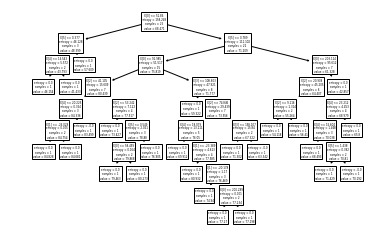

In [1701]:
# Shows the tree model
tree.plot_tree(clf)

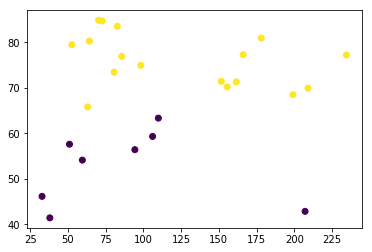

In [916]:
# Shows training data
plt.scatter('Average Heading Range', 'Accuracy', data = df_joined_training, c = (df_joined_training['Quality'] == '1'))

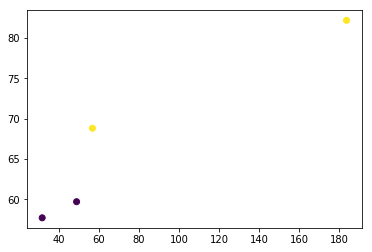

In [918]:
# Shows Test Data
plt.scatter('Average Heading Range', 'Accuracy', data = df_joined_test, c = (df_joined_test['Quality'] == '1'))

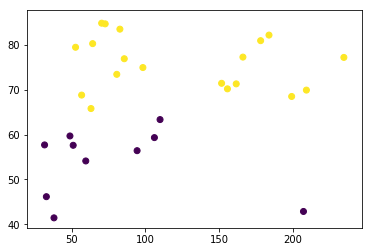

In [1035]:
# Shows all data
plt.scatter('Average Heading Range', 'Accuracy', data = df_joined_training, c = (df_joined_training['Quality'] == '1'))
plt.scatter('Average Heading Range', 'Accuracy', data = df_joined_test, c = (df_joined_test['Quality'] == '1'))

In [33]:
# Creates dataframes of all the label locations, and one of all of their accuracies
df_finished_labeling = pd.read_csv('LabelingCanvas_FinishLabeling.csv')
df_all_labels = pd.read_csv('ml-label-correctness.csv')

In [147]:
# Sorts both dataframes in the same order so that accuracies line up with location
df_finished_labeling.set_index(['audit_task_id', 'temporary_label_id'], inplace=True)
df_all_labels.set_index(['audit_task_id', 'temporary_label_id'], inplace=True)
df_all_labels.drop(columns=('user_id'), inplace=True)

In [148]:
# creates a new dataframe containing all of the information
df_joined = df_finished_labeling.join(df_all_labels)
df_joined = df_joined[~pd.isna(df_joined['correct'])]
df_joined = df_joined[df_joined['lat'] > 46]
df_joined.to_csv('all_labels.csv', encoding='utf-8', index=False)

In [193]:
# Creates a csv file of the label data to be inputted into the cv model
df_cv = pd.DataFrame(cv_data, columns = cv_heading, index = cv_label_id)
df_cv.to_csv('Quality_Inferance_for_cv.csv', encoding='utf-8', index=False)

In [101]:
# Creates a dataframe of all of the seattle label's with their sv coordinates
df_sv_x_sv_y = pd.read_csv('sidewalk-seattle-label_point.csv')

In [190]:
# Creates a dataframe of all of the cv information fo each label
cv_data = []
cv_label_id = []
cv_heading = ['Timestamp', 'pano_id', 'sv_x', 'sv_y', 'label_type', 'label_id', 'user_id']
for index, current in enumerate(df_joined['label_id']):
    users_index = (df_sv_x_sv_y['label_id'] == current).idxmax()
    current_label = [df_joined['timestamp'].iloc[index], df_joined['gsv_panorama_id'].iloc[index], 
                     df_sv_x_sv_y['sv_image_x'].iloc[users_index], df_sv_x_sv_y['sv_image_y'].iloc[users_index],
                     df_joined['label_type'].iloc[index], current, df_joined['user_id'].iloc[index]]
    cv_label_id.append(current)
    cv_data.append(current_label)

In [83]:
df_summary = pd.read_csv('summary_user.csv')
display(df_summary)

,timestamp,pano_id,sv_x,sv_y,CVLabel,UserLabel,Confidence,Label_id,User_id,Correctness
0,45:55.6,_A5rFjTmvnz4rrDVYUvdzw,9159,-462,CurbRamp,CurbRamp,53,19625,2d9009b3-55d5-4aa8-a17a-a7c80afc4d51,NaN
1,38:54.5,_AuEwT7f-loA1AdF30qFbg,11603,-365,CurbRamp,NoCurbRamp,66,18966,2d9009b3-55d5-4aa8-a17a-a7c80afc4d51,NaN
2,38:35.2,_AuEwT7f-loA1AdF30qFbg,12007,-357,CurbRamp,CurbRamp,59,18964,2d9009b3-55d5-4aa8-a17a-a7c80afc4d51,NaN
3,11:02.1,_grxIPnooH-FP0Z4uQHIrQ,9472,-953,CurbRamp,CurbRamp,57,17270,49723673-044d-4b47-855b-3bdebfe37073,NaN
4,30:14.9,_ibiO9vI2iMSrzbUw5WdCg,12204,-399,CurbRamp,CurbRamp,53,14640,2d9009b3-55d5-4aa8-a17a-a7c80afc4d51,NaN
5,04:41.1,_iDwdi871owPHsEmSf3b4g,11630,-285,CurbRamp,SurfaceProblem,58,32932,ec15a589-dd14-4513-a43e-8c06e55f4c71,NaN
6,20:57.2,_IJJLin7DnousYsQO1xzyQ,11770,-445,CurbRamp,SurfaceProblem,52,11836,0e1ae564-6d72-4670-98e4-71369cc5ab26,NaN
7,07:38.6,_jOJrjgOYeXSFxH7Wnj9zw,4585,-624,CurbRamp,NoCurbRamp,52,70104,49723673-044d-4b47-855b-3bdebfe37073,NaN
8,22:25.0,_jOJrjgOYeXSFxH7Wnj9zw,8912,-556,CurbRamp,NoCurbRamp,52,17332,49723673-044d-4b47-855b-3bdebfe37073,NaN
9,22:31.6,_jOJrjgOYeXSFxH7Wnj9zw,11883,-666,CurbRamp,NoCurbRamp,50,17334,49723673-044d-4b47-855b-3bdebfe37073,NaN


In [268]:
# Checks the number of trues and false validations & the average confidence for both
df_temp = df_summary.groupby(['Correctness'])
for name,group in df_temp:
    print(name)
    print (group.agg(np.size))
    print(group.mean())

f
timestamp      10
pano_id        10
sv_x           10
sv_y           10
CVLabel        10
UserLabel      10
Confidence     10
Label_id       10
User_id        10
Correctness    10
dtype: int64
sv_x          7502.7
sv_y          -551.7
Confidence      56.4
Label_id      1427.2
dtype: float64
t
timestamp      649
pano_id        649
sv_x           649
sv_y           649
CVLabel        649
UserLabel      649
Confidence     649
Label_id       649
User_id        649
Correctness    649
dtype: int64
sv_x          6475.411402
sv_y          -587.191063
Confidence      54.473035
Label_id       584.926040
dtype: float64


In [266]:
# Adds the correctness of each user label of the cv analysis
for current_id in df_summary['Label_id']:
    label_index = (df_all_labels['label_id'] == current_id).idxmax()
    correctness = df_all_labels['correct'].iloc[label_index[0]]
    if current_id in df_summary['Label_id']:
        results_index = (df_summary['Label_id'] == current_id).idxmax() 
        df_summary['Correctness'].iloc[results_index] = correctness

In [276]:
# Checks how many labels that the cv and user has agreed on and whether they are correct or now
true = 0
false = 0
for current_id in df_summary['Label_id']:
    label_index = (df_summary['Label_id'] == current_id).idxmax()
    if df_summary['CVLabel'].iloc[label_index] == df_summary['UserLabel'].iloc[label_index]:
        if df_summary['Correctness'].iloc[label_index] == 'f':
            false += 1
        elif df_summary['Correctness'].iloc[label_index] == 't':
            true += 1
display(true)
display(false)

233

3

In [269]:
df_summary.to_csv('summary_user.csv', encoding='utf-8', index=False)

In [214]:
# Checks how many panos have had multiple users label
df_cv_grouped = df_summary.groupby(['pano_id'])
multiple_users = 0
for name, group in df_cv_grouped:
    if group['User_id'].nunique() != 1:
        multiple_users += 1
display(multiple_users)
display(len(df_cv_grouped))

51

2467

In [209]:
# Calculates the percentage that the CV model agrees with each user
df_cv_grouped = df_summary.groupby(['User_id'])
for name, group in df_cv_grouped:
        correct = 0
        total = 0
        for index, current in enumerate(group['CVLabel']):
            total += 1
            if current == group['UserLabel'].iloc[index]:
                correct += 1
        display(name)
        display(str(correct) + '/' + str(total) + '=' + str(float(correct) / float(total)))

'0e1ae564-6d72-4670-98e4-71369cc5ab26'

'75/257=0.2918287937743191'

'1353d168-ab49-4474-ae8a-213eb2dafab5'

'31/67=0.4626865671641791'

'2d9009b3-55d5-4aa8-a17a-a7c80afc4d51'

'149/413=0.36077481840193704'

'35872a6c-d171-40d9-8e66-9242b835ea71'

'6/19=0.3157894736842105'

'49723673-044d-4b47-855b-3bdebfe37073'

'217/802=0.27057356608478805'

'54c77d0f-fc8f-4497-84d3-5e336047b17e'

'18/43=0.4186046511627907'

'6809bd6e-605f-4861-bc49-32e52c88c675'

'3/11=0.2727272727272727'

'715af4d8-0f17-47c4-99c6-7ef92d94803a'

'60/174=0.3448275862068966'

'7b1596af-14d4-4f2b-9e4e-71b1884db836'

'4/14=0.2857142857142857'

'86d26e9d-010f-4802-88ba-680ae0a8e20d'

'56/172=0.32558139534883723'

'87833d72-b357-4e2c-81cd-23f58ff04c59'

'133/335=0.3970149253731343'

'8a471c0f-fa81-4c57-9b65-bd04a92c6a5e'

'13/52=0.25'

'939b6faa-0b57-4160-bcc2-d11fd2b69d9f'

'42/163=0.25766871165644173'

'9b595ba6-529b-4d37-93d7-dd189184e15a'

'54/163=0.3312883435582822'

'ac272eb8-3bb3-4260-9960-8e6c463f3867'

'12/25=0.48'

'af812204-1521-4c42-bf88-4baaaffe3f06'

'37/112=0.33035714285714285'

'bb64c416-b0bb-4a5b-b369-00f2a56fea3a'

'16/42=0.38095238095238093'

'bca24c1a-a6b1-4625-ab8e-9ff8693022d7'

'58/168=0.34523809523809523'

'bf16418a-4c99-4fd6-99c6-7e8b40fbe17b'

'63/191=0.3298429319371728'

'c7190807-b56e-40c5-b96e-49dc8368328c'

'3/11=0.2727272727272727'

'd3636d4c-2d16-410c-bf44-c066ecaf1c31'

'2/12=0.16666666666666666'

'dada416e-535f-4bb3-a213-172a8a94b581'

'32/100=0.32'

'dce5984b-25d9-48f9-b8b7-640202b3be3c'

'0/2=0.0'

'e4ff325c-309b-4ea6-8555-8f973e662362'

'109/283=0.38515901060070673'

'ec15a589-dd14-4513-a43e-8c06e55f4c71'

'29/88=0.32954545454545453'

'f13d2630-35fd-4a78-883d-d108be083425'

'29/81=0.35802469135802467'

'f5314ef9-3877-438c-ba65-ee2a2bbbf7f5'

'15/42=0.35714285714285715'

'fa0bbee4-b98d-4eb3-b6da-d9e9aa287f6c'

'81/259=0.3127413127413127'

In [45]:
# Checks the number of labels in every pano
df_joined_groups = df_joined.groupby(['gsv_panorama_id'])
for name,group in df_joined_groups:
    if len(group['gsv_panorama_id'].agg(np.size)) > 7:
        print(name)
        display(len(group['gsv_panorama_id'].agg(np.size)))

0o5UD2lV47rsCz1NNl2_WQ


12

4Czt4q0BsHpIvLTRccKRuQ


12

55JjCbPXgFP2w7ubAXi7Vw


24

_ThcAfjL-9PVTI2IGWcIkg


9

aP5ZY6IHE3lziMBQQutnVg


10

oqP7byVfpym5eotQ9U4fdA


9

wuk--sZ3fJyMsMo4tJuybg


9

xknXWuoxVvX58NGN6sJ2vQ


9

In [1020]:
# Creates a csv of all of the labels of each users
for current_user in users['user_id']:
    current_correctness = df_joined[df_joined['user_id'] == current_user]
    current_correctness.to_csv('{0}_correctness.csv'.format(current_user), encoding='utf-8', index=False)

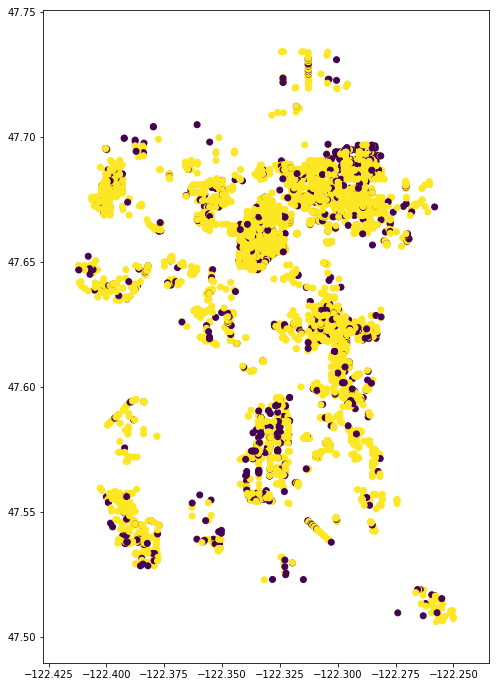

In [395]:
# Plots all validated labels
plt.figure(figsize=(8, 12))
plt.scatter(df_joined['lng'], df_joined['lat'], c = (df_joined['correct'] == 't'))

In [34]:
# Determines a user's accuracy for each of the label types
df_all_grouped = df_all_labels.groupby(['user_id','label_type'])
label_type_accuracy = {}
for current, group in df_all_grouped:
    users_index = (users['user_id'] == current[0]).idxmax()
    correct = sum(group['correct'] == 't')
    false = sum(group['correct'] =='f')
    if correct + false != 0:
        label_type_accuracy[current] = (correct / (correct + false))

In [84]:
# Plots a given feature against the user's accuracy on the 4 label types
def label_accuracy_per_type(feature_name):
    f, axs = plt.subplots(2,2,figsize=(12,8))
    plt.subplot(221)
    label_type_accuracy_graph('CurbRamp', feature_name)
    plt.subplot(222)
    label_type_accuracy_graph('NoCurbRamp', feature_name)
    plt.subplot(223)
    label_type_accuracy_graph('Obstacle', feature_name)
    plt.subplot(224)
    label_type_accuracy_graph('SurfaceProblem', feature_name)

In [85]:
# Plots features versus accuracies of different label types
def label_type_accuracy_graph(label_type, feature_name):
    user_information = {}
    for index, current_user in enumerate(users['user_id']):
        feature_info = df_all.at[current_user, feature_name]
        user_information[current_user] = feature_info , label_type_accuracy[current_user,label_type] 
    label_scatter_plot(feature_name, user_information, label_type)

In [86]:
# Plots the feature versus the label type accuracy
def label_scatter_plot(info_type, user_information, label_type):
    for entry in user_information.keys():
        users_index = (users['user_id'] == entry).idxmax()
        user_info = user_information.get(entry)
        info = user_info[0]
        accuracy = user_info[1]
        user_accuracy = users.at[users_index,'accuracy']
        if entry in overall_bad_users:
            current_color = 'red'
        elif user_accuracy < 65:
            current_color = 'black'
        else:
            current_color = 'blue'
        plt.plot(info, accuracy, '.', color = current_color)
    temp = np.array(list(user_information.values()))
    z = np.polyfit(temp[:,0],temp[:,1],1)
    w = np.poly1d(z)
    pears= scipy.stats.pearsonr(temp[:,1], w(temp[:,0]))
    plt.plot(temp[:,0],w(temp[:,0]))
    plt.legend(['R =' + str(f'{pears[0]:.2f}')])

In [89]:
label_accuracy_per_type('Average Pitch')

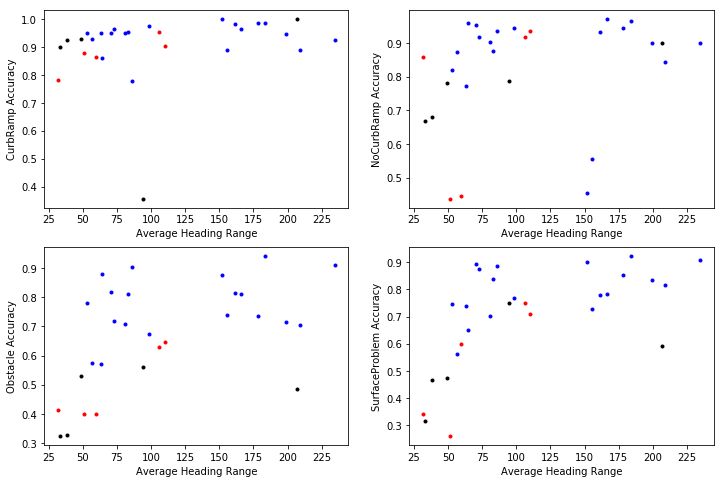

In [1521]:
label_accuracy_per_type('Average Heading Range')

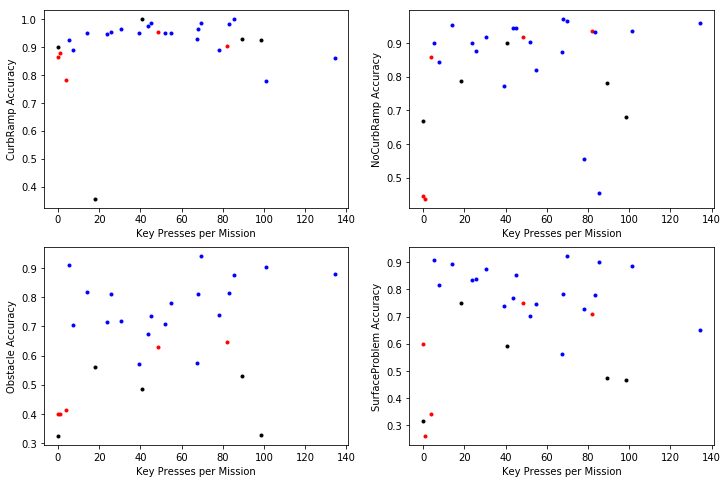

In [1522]:
label_accuracy_per_type('Key Presses per Mission')

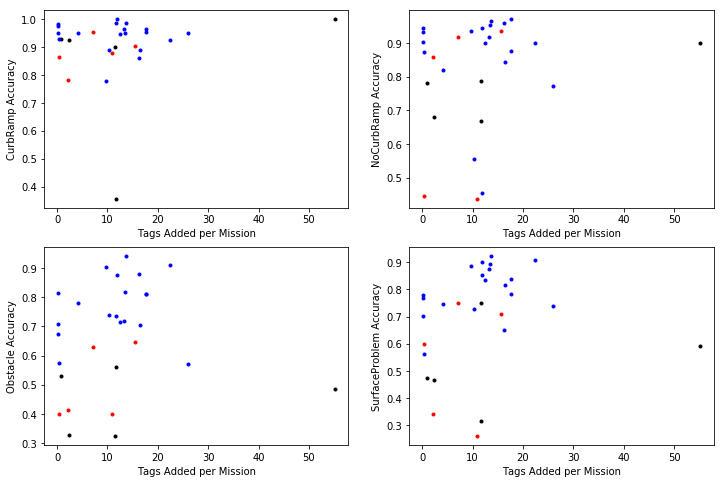

In [1523]:
label_accuracy_per_type('Tags Added per Mission')

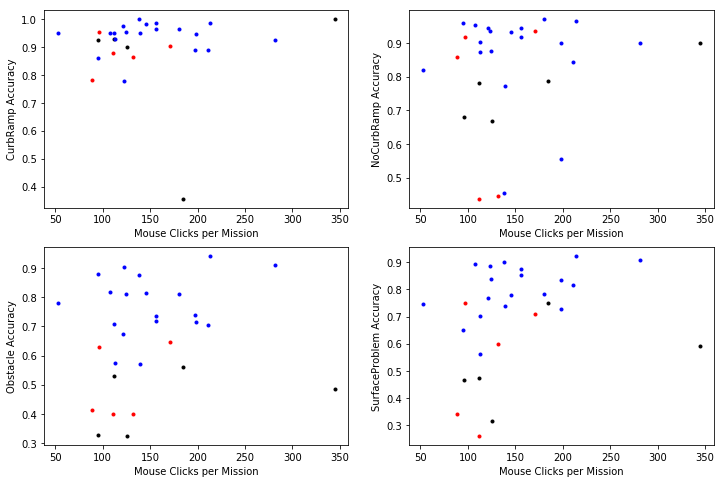

In [1524]:
label_accuracy_per_type('Mouse Clicks per Mission')

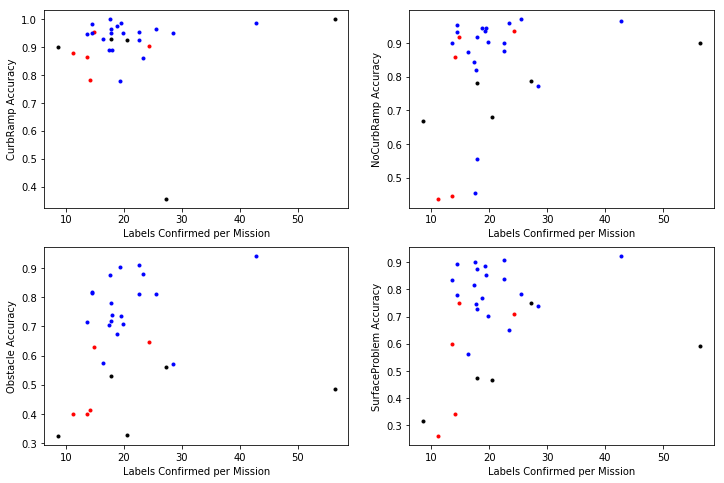

In [1525]:
label_accuracy_per_type('Labels Confirmed per Mission')

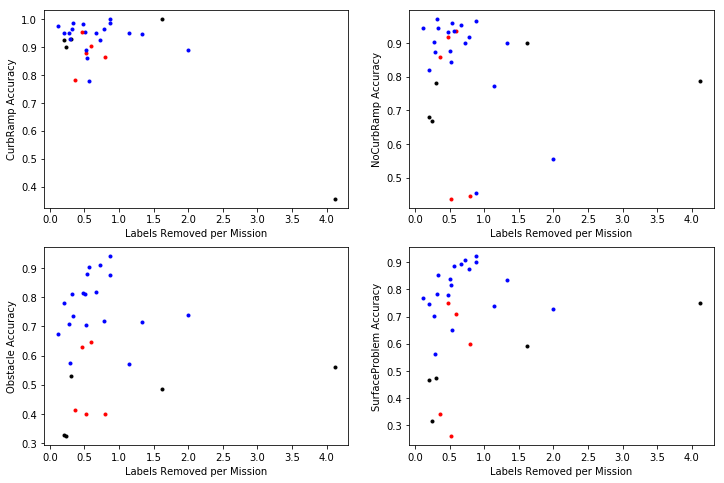

In [1526]:
label_accuracy_per_type('Labels Removed per Mission')

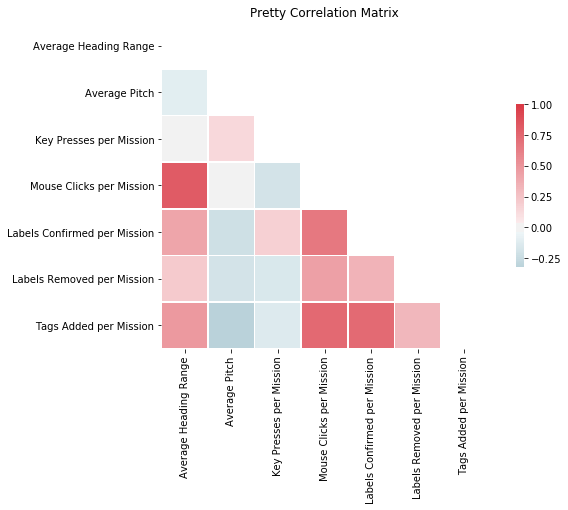

In [1574]:
# Compute the correlation matrix
corr = df_all.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from (mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Pretty Correlation Matrix')
# Generate a custom diverging colormap
cmap = sns.diverging_palette (220, 10, as_cmap=True)
# Draw heatmap w/the mask & correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5,cbar_kws={"shrink":.5})

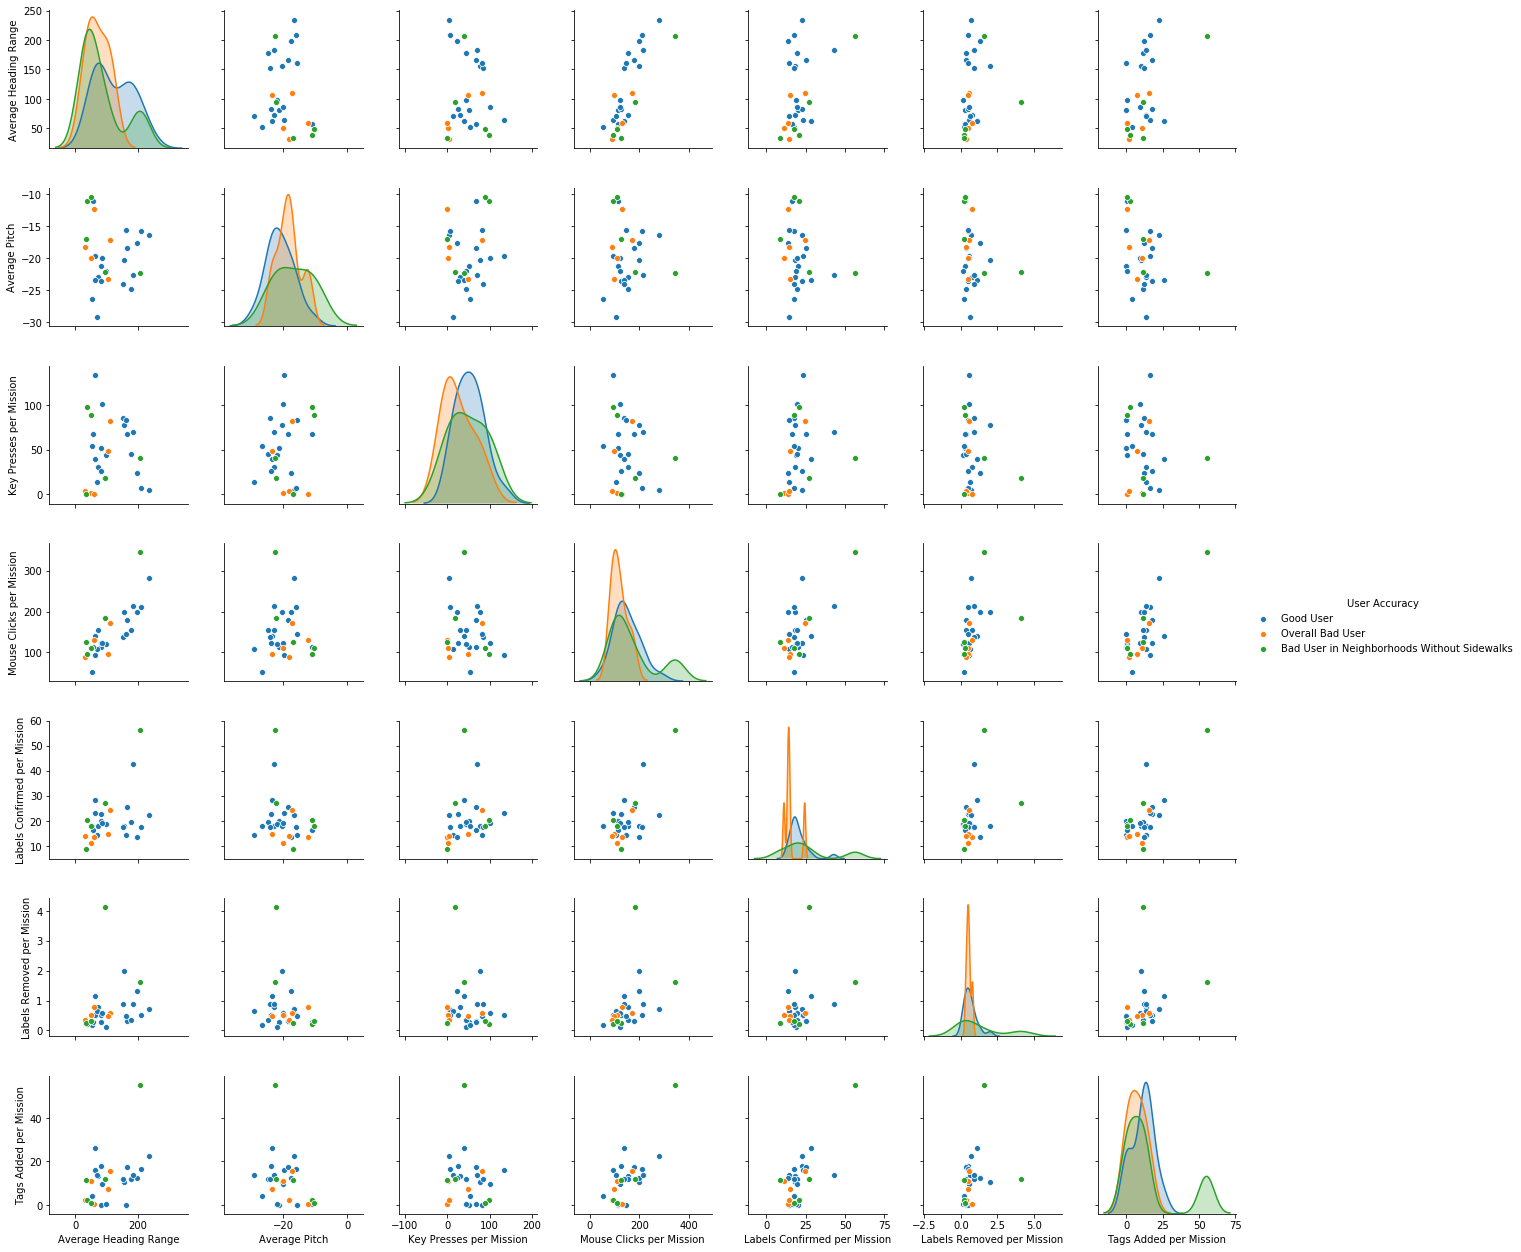

In [1573]:
# Compares how different features are related to each other
sns_plot = sns.pairplot(df_all, hue='User Accuracy')

In [159]:
df_all_new = pd.read_csv('users_one_mission.csv')
display(df_all_new)

,user_id,total_labels,labels_validated,correct_labels,false_labels,accuracy,missions_completed
0,0e1ae564-6d72-4670-98e4-71369cc5ab26,7194,1690,1321,369,78.165680,364
1,bca24c1a-a6b1-4625-ab8e-9ff8693022d7,5240,737,536,201,72.727273,184
2,49723673-044d-4b47-855b-3bdebfe37073,4950,1365,1204,161,88.205128,219
3,ec15a589-dd14-4513-a43e-8c06e55f4c71,4904,886,564,322,63.656885,275
4,f13d2630-35fd-4a78-883d-d108be083425,4881,1217,906,311,74.445357,297
5,715af4d8-0f17-47c4-99c6-7ef92d94803a,4629,592,495,97,83.614865,198
6,af812204-1521-4c42-bf88-4baaaffe3f06,4574,639,529,110,82.785602,257
7,2d9009b3-55d5-4aa8-a17a-a7c80afc4d51,4337,1063,951,112,89.463782,243
8,bf16418a-4c99-4fd6-99c6-7e8b40fbe17b,2540,482,400,82,82.987552,132
9,7b1596af-14d4-4f2b-9e4e-71b1884db836,1935,541,437,104,80.776340,103


In [171]:
all_info = {}
for index, current_id in enumerate(df_all_new['user_id']):
    missions_completed = df_all_new['missions_completed'][index]
    total_labels = df_all_new['total_labels'][index]
    accuracy = df_all_new['accuracy'][index]
    if total_labels > 26:
        all_info[current_id] = float(total_labels) / float(missions_completed), missions_completed, accuracy

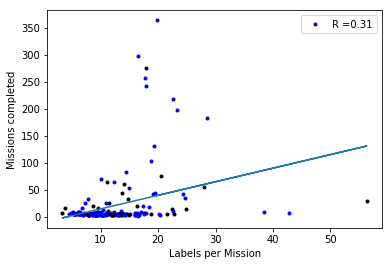

In [179]:
user_information = all_info
plt.ylabel('Missions completed')
plt.xlabel('Labels per Mission')
for entry in user_information.keys():
    user_info = user_information.get(entry)
    info = user_info[0]
    missions = user_info[1]
    accuracy = user_info[2]
#     if entry in overall_bad_users:
# #         if accuracy > 65:
#         plt.plot(info, missions, '.', color = 'red')
    if accuracy < 70:
            plt.plot(info, missions, '.', color = 'black')
    else:
        plt.plot(info, missions, '.', color = 'blue')
temp = np.array(list(user_information.values()))
z = np.polyfit(temp[:,0],temp[:,1],1)
w = np.poly1d(z)
pears= scipy.stats.pearsonr(temp[:,1], w(temp[:,0]))
plt.plot(temp[:,0],w(temp[:,0]))
plt.legend(['R =' + str(f'{pears[0]:.2f}')])